In [1]:
import mido
from mido import MidiFile
import numpy as np
import copy
import sys

HEARING_PORT = mido.open_output()
np.set_printoptions(threshold=np.nan)

In [2]:
class Song:
    def __init__(self, name):
        self.name = name
        self.correct = True
        self.notes = np.zeros((128, 13), dtype=int)#-np.ones((128, 13))
        
        if isinstance(name, str):        
            maxnote = 0
            minnote = 127
            for msg in MidiFile(name):
                if (msg.type == "note_on" and msg.velocity > 0):
                    if msg.note < minnote:
                        minnote = msg.note
                    if msg.note > maxnote:
                        maxnote = msg.note
            if maxnote - minnote >= 13:
                print("ERROR! out of range!")
                self.correct = False
                return

            shift = 0
            if minnote < 60:
                shift = 60 - minnote
            if maxnote >= 60 + 13:
                shift = 60 + 13 - 1 - maxnote

            absolute_time_passed = 0
            for msg in MidiFile(name):
                absolute_time_passed += msg.time

                if (msg.type == "note_on" and msg.velocity > 0):
                    self.notes[round(absolute_time_passed / 0.25)][msg.note - 60 + shift] = 1
        else:
            for i, note in enumerate(name):
                if note >= 0 and note < 13:
                    self.notes[i][note] = 1
                
    def play(self):
        for msg in MidiFile(self.name).play():
            HEARING_PORT.send(msg)
            
    def transpose(self, shift):
        if (not self.correct or
           (shift > 0 and self.notes[:, -shift:].sum() != 0) or
           (shift < 0 and self.notes[:, :-shift].sum() != 0)):
            return False
        
        self.notes = np.hstack([self.notes[:, -shift:], self.notes[:, :-shift]])
        return True

In [3]:
class MySong:
    def __init__(self, played_lines=[]):
        self.notes = np.zeros((0, 13))
        
        self.mid = MidiFile()
        self.track = mido.MidiTrack()
        self.mid.tracks.append(self.track)
        
        self.time_passed = 0
        self.release = []
        
        for line in played_lines:
            self.add(line)
        
    def add(self, played):
        self.notes = np.vstack([self.notes, played])

        for i in self.release:        
            self.track.append(mido.Message('note_off', note=60+i, velocity=64, time=self.time_passed))
            self.time_passed = 0
        self.release = []

        for i, key in enumerate(played):
            if key == 1:
                self.track.append(mido.Message('note_on', note=60+i, velocity=64, time=self.time_passed))
                self.time_passed = 0
                self.release.append(i)
        self.time_passed += 256
    
    def finish(self):
        for i in self.release:        
            self.track.append(mido.Message('note_off', note=60+i, velocity=64, time=self.time_passed))
            self.time_passed = 0
        self.track.append(mido.Message('note_off', note=60, velocity=0, time=self.time_passed))
        
    def play(self):
        for msg in self.mid.play():
            HEARING_PORT.send(msg)
            
    def save_file(self, name):
        self.mid.save(name + '.mid')

# ОКИ

In [92]:
import numpy as np
from numpy import random
from graphviz import Graph

import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
MEMORY_TIMES = 32
STARTER = 8

ADDITIONAL_MEMORY = 8

MEMORY_SIZE = MEMORY_TIMES * 13 + ADDITIONAL_MEMORY

In [94]:
NOTE_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B", "C^"]
NAMES = []
for i in range(8):
    NAMES.append("[tb" + str(i) + "]")
for t in range(-MEMORY_TIMES, 0):
    for note_name in NOTE_NAMES:
        NAMES.append(note_name + str(t))

In [197]:
TURNED = []
class Neuron:
    def __init__(self, name, layer, isnot=False):
        self.name = name
        self.layer = layer
        
        self.outputs = []
        self.cnt = 0
        self.n = isnot
        
        self.inputs = []
        self.rewards = []
        
    def signal(self):
        self.cnt += 1
        
    def emit(self):
        if ((not self.n and self.cnt > len(self.inputs) // 2) or
            (self.n and self.cnt <= len(self.inputs) // 2)):
            TURNED.append(self)
            for neuron in self.outputs:
                neuron.signal()
                
    def reward(self, true_val):
        if self.n:
            true_val = not true_val
            
        decision = self in TURNED
        
        for i, inp in enumerate(self.inputs):
            my_val = inp in TURNED  
            if my_val == decision:              
                if my_val == true_val:
                    self.rewards[i][true_val] += 1
                else:
                    self.rewards[i][true_val] -= 1
                inp.reward(true_val)

In [198]:
class Func:
    def __init__(self, layers, verbose=False):
        self.layers = layers
        self.neurons = [Neuron(NAMES[i], 0) for i in range(MEMORY_SIZE)]
        for i in range(13):
            self.neurons.append(Neuron(NOTE_NAMES[i] + "outp", layers)) 
        self.ids = len(self.neurons)       
        
        self.Random = np.random.RandomState(seed=179)
        
        self.verbose = verbose
        self.depth = ""
        
        self.learning_rate = 1
        
    def apply(self, x):
        global TURNED
        TURNED = []
        for neuron in self.neurons:
            neuron.cnt = 0
            
        for i, val in enumerate(x):
            if val == 1:
                self.neurons[i].signal()
                
        for layer in range(0, self.layers + 1):
            for N in self.neurons:
                if N.layer == layer:
                    N.emit()
                
        return np.array([self.neurons[MEMORY_SIZE + i] in TURNED for i in range(13)])
    
    def reward(self, true_vals):
        for i, val in enumerate(true_vals):
            self.neurons[i + MEMORY_SIZE].reward(val)
    
    def randomOne(self, layer):
        while True:
            N = TURNED[self.Random.randint(len(TURNED))]
            if N.layer < layer:
                return N
    def connect(self, N1, N2):
        if N1 in N2.inputs:
            if self.verbose:
                print(self.depth, "tried to create existing edge, procedure failed")
            return False
        
        if self.verbose:
            print(self.depth, "new edge between layers: ", N1.name, "(", N1.layer, ")", " / ", N2.name, "(", N2.layer, ")")
        N1.outputs.append(N2)
        N2.inputs.append(N1)
        N2.rewards.append([0, 1])
        return True
    def disconnect(self, N1, N2):
        if self.verbose:
            print(self.depth, "remove edge between layers: ", N1.name, "(", N1.layer, ")", " / ", N2.name, "(", N2.layer, ")")
        N1.outputs.remove(N2)
        del N2.rewards[N2.inputs.index(N1)]
        N2.inputs.remove(N1)
        
        if len(N1.outputs) == 0 and N1.layer != 0:
            if self.verbose:
                print(self.depth, "neuron destroyed: ", N1.name, "(", N1.layer, ")")
            for inp in N1.inputs:
                self.disconnect(inp, N1)
            if N1 in TURNED:
                TURNED.remove(N1)         
            self.neurons.remove(N1)
    def add_reason(self, conseq):
        if conseq.layer <= 1:
            if self.verbose:
                print(self.depth, "no place for reason :(")
            return None
        
        reason = Neuron("rsn" + str(self.ids), self.Random.randint(1, conseq.layer), True)
        self.neurons.append(reason)
        self.ids += 1
        
        if self.verbose:
            print(self.depth, "created reason ", reason.name, " (", reason.layer, ")")
        
        self.connect(reason, conseq)        
        return reason
    def add_stub(self, cause, conseq, stublayer):
        if conseq.layer <= 1 or conseq.layer - cause.layer <= 1:
            if self.verbose:
                print(self.depth, "no place for stub :(")
            return None
        
        stub = Neuron("stub" + str(self.ids), stublayer)
        self.neurons.append(stub)
        self.ids += 1
        
        if self.verbose:
            print(self.depth, "created stub ", stub.name, " (", stublayer, ")")
        
        self.connect(cause, stub)
        self.connect(stub, conseq)
        self.disconnect(cause, conseq)
        
        return stub
        
    def turn(self, N, pos):
        self.depth += "    "
        if N.layer == 0:
            if self.verbose:
                print(self.depth, N.name, " is input neuron, procedure failed")
            self.depth = self.depth[:-4]
            return False
        
        if self.verbose:
            print(self.depth, "turning ", pos, ": ", N.name)
            
        if N.n:
            pos = not pos
            if self.verbose:
                print(self.depth, "actualy ", pos, ": ", N.name)
        
        #votes = self.neurons[ID].cnt
        #thr = (len(self.neurons[ID].inputs) + 1) // 2
        
        min_rew = 1
        for inp, rew in zip(N.inputs, N.rewards):
            if (inp in TURNED) != pos and rew[int(pos)] < min_rew:
                min_rew = rew[int(pos)]
                taken = inp
        
        if min_rew >= 0:
            if pos == 1:                                                               # добавлять новые нити
                result = False
                for i in range(self.learning_rate):
                    one = self.randomOne(N.layer)
                    result = result or self.connect(one, N)
            else:                                                                      # добавлять причины
                result = self.add_reason(N)
                if not result is None:
                    result = self.turn(result, pos)
                else:
                    result = False
        elif min_rew < -1:
            self.disconnect(taken, N)
            result = True
        else:
            stublayer = self.Random.randint(1, self.layers)                          # разрубать ведущие нити 
            if taken.layer < stublayer and stublayer < N.layer:
                stub = self.add_stub(taken, N, stublayer)
                result = self.turn(stub, pos)
            else:                                                                      # рекурсивно переключать входы
                result = self.turn(taken, pos)              
        
        if self.verbose and not result:
            print(self.depth, "procedure failed")
        self.depth = self.depth[:-4]
        return result
    
    def draw(self):
        dot = Graph(format='png')
        for N in self.neurons:
            dot.node(N.name)
        for N in self.neurons:
            for inp, r in zip(N.inputs, N.rewards):
                dot.edge(inp.name, N.name, label = str(r[0])  + "/" + str(r[1]))
        #dot.render(view=True)
        return dot

In [199]:
class Player:
    def __init__(self):
        self.play_note = Func(10)
           
    def learn_to_play(self, song_to_learn, verbose=False, learn=True, limit = -1):
        if limit == -1:
            limit = len(song_to_learn.notes)
        self.play_note.verbose = verbose
        
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = song_to_learn.notes[:STARTER].flatten()

        t = STARTER
        memory[t % 8] = 1
        errors = 0
        
        while t < limit:    
            output = self.play_note.apply(memory)
            self.play_note.reward(song_to_learn.notes[t])
            
            if verbose:
                print(output.astype(int))
            
            for note in range(13):    
                if output[note] != song_to_learn.notes[t][note]:
                    errors += 1
                    if learn:
                        if output[note] == 0:
                            self.play_note.turn(self.play_note.neurons[note + MEMORY_SIZE], 1)
                        else:
                            self.play_note.turn(self.play_note.neurons[note + MEMORY_SIZE], 0)
            
            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], song_to_learn.notes[t]])
            t += 1
            memory[t % 8] = 1
            
        return errors
    
    def improvise(self, starter, length=128):
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = starter.notes[:STARTER].flatten()

        result = MySong(starter.notes[:STARTER])
        
        t = STARTER
        memory[t % 8] = 1
        while t < length:    
            output = self.play_note.apply(memory)
            result.add(output)

            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], output])
            t += 1
            memory[t % 8] = 1
        result.finish()
        
        return result

## Обучение

Создаём нового игрока и грузим пока кузнечика

In [206]:
player = Player()

In [201]:
kuznechik = Song('test/track (1).mid')

In [202]:
player.learn_to_play(kuznechik, verbose=True, limit=13)

[0 0 0 0 0 0 0 0 0 0 0 0 0]
     turning  1 :  Aoutp
     new edge between layers:  A-8 ( 0 )  /  Aoutp ( 10 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
     turning  1 :  G#outp
     new edge between layers:  A-6 ( 0 )  /  G#outp ( 10 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0]
     turning  1 :  G#outp
     new edge between layers:  E-10 ( 0 )  /  G#outp ( 10 )
     turning  0 :  Aoutp
     created reason  rsn437  ( 5 )
     new edge between layers:  rsn437 ( 5 )  /  Aoutp ( 10 )
         turning  0 :  rsn437
         actualy  True :  rsn437
         new edge between layers:  E-10 ( 0 )  /  rsn437 ( 5 )


4

In [216]:
player.play_note.draw()

In [205]:
limit = 8
neurons = [MEMORY_SIZE + 13]

while limit < 64:#len(kuznechik.notes):
    print("limit: ", limit)
    errors = [kuznechik.notes[:limit].sum()]
    while errors[-1] > 0:
        errors.append(player.learn_to_play(kuznechik, limit=limit))
        neurons.append(len(player.play_note.neurons))
        print(errors[-1], end=" ")
        sys.stdout.flush()
    print("")
    limit += 1

limit:  8
0 
limit:  9
0 
limit:  10
0 
limit:  11
0 
limit:  12
0 
limit:  13
0 
limit:  14
0 
limit:  15
0 
limit:  16
0 
limit:  17
0 
limit:  18
0 
limit:  19
0 
limit:  20
0 
limit:  21
0 
limit:  22
0 
limit:  23
0 
limit:  24
0 
limit:  25
0 
limit:  26
0 
limit:  27
0 
limit:  28
0 
limit:  29
2 7 5 7 7 5 6 6 6 9 4 5 3 1 2 3 2 3 1 2 1 1 2 1 2 2 1 1 0 
limit:  30
0 
limit:  31
1 3 3 2 2 2 1 2 2 2 3 3 2 3 2 2 1 0 
limit:  32
0 
limit:  33
1 3 4 2 2 2 4 4 2 1 1 2 1 2 1 3 2 4 3 4 3 4 3 2 3 1 0 
limit:  34
0 
limit:  35
1 5 3 1 0 
limit:  36
0 
limit:  37
2 3 6 4 3 4 6 7 5 3 2 1 1 1 1 1 1 1 1 1 1 3 2 3 5 5 1 3 4 2 4 3 1 2 1 2 1 1 2 3 2 3 3 5 1 2 1 1 2 1 1 1 1 0 
limit:  38
0 
limit:  39
1 1 1 2 0 
limit:  40
0 
limit:  41
1 1 1 1 1 1 1 1 1 1 1 0 
limit:  42
0 
limit:  43
2 2 5 4 5 3 3 2 4 3 3 8 9 5 3 2 5 2 0 
limit:  44
0 
limit:  45
1 2 2 2 2 0 
limit:  46
0 
limit:  47
1 5 4 3 7 3 4 5 5 4 5 7 4 3 2 3 3 2 1 2 2 1 1 0 
limit:  48
0 
limit:  49
0 
limit:  50
0 
limit:  51
0 
limit:  

KeyboardInterrupt: 

In [210]:
errors = [kuznechik.notes.sum()]
neurons = [MEMORY_SIZE + 13]
while errors[-1] > 20:
    errors.append(player.learn_to_play(kuznechik))
    neurons.append(len(player.play_note.neurons))
    print(errors[-1], end=" ")
    sys.stdout.flush()
    
    #if errors[-1] > errors[-2]:
    #    player.play_note.learning_rate += 1

38 30 31 36 39 33 43 38 31 31 28 25 25 26 30 26 33 30 34 27 23 23 25 27 25 34 30 31 32 24 28 38 31 32 26 25 34 28 33 30 33 33 29 24 27 35 28 28 32 29 33 36 31 30 24 26 31 30 33 33 24 25 25 24 19 

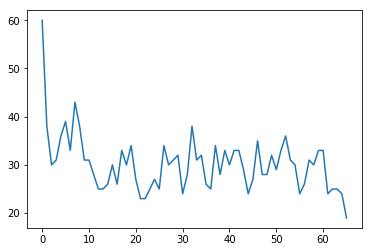

In [211]:
plt.plot(errors)

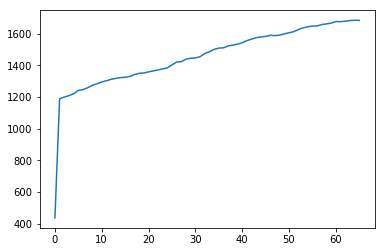

In [212]:
plt.plot(neurons)

In [197]:
ENS = 20
best_player = Player()
error = 1000
epoch = 0
CRS = np.random.RandomState(seed=179)

while error != 0:
    print("EPOCH ", epoch)
    
    candidates = [copy.deepcopy(best_player) for i in range(ENS)]
    errors = []
    for i in range(ENS):
        candidates[i].play_note.Random = CRS
        candidates[i].learn_to_play(kuznechik)
        errors.append(candidates[i].learn_to_play(kuznechik, learn=False))
    
    errors = np.array(errors)
    error = errors.min()
    print(errors, error)
    best_player = copy.deepcopy(candidates[errors.argmin()])
    epoch += 1

EPOCH  0
[131  47  66  53  85  56 119  56  50  97  59  52 129  81  53  55  75  57
 126  55] 47
EPOCH  0
[ 61  50  49  48  43  63  53  51  41  38  48  49  45  55  46  52  48 129
 137  47] 38
EPOCH  0
[ 48 203  49 129  69  41  51 186 147  57 103  62  84 137  70 134 152  60
  74  58] 41
EPOCH  0
[109  56  79  47  69 127  45  54  55  49  54  53  50  48  74  54  93  98
  63  61] 45
EPOCH  0
[ 46  50  51 122  46  60  49  50  46  41  41 110  45  65  43 112  53  44
  54  43] 41
EPOCH  0
[49 48 40 47 46 42 34 43 56 53 45 42 53 47 45 78 38 53 49 59] 34
EPOCH  0
[39 36 35 32 46 38 34 41 36 40 38 35 40 54 41 43 39 38 37 39] 32
EPOCH  0
[ 38  39 134  40  44  54 116  38  56  41  38  40  64  41  33  59  42 120
 113  44] 33
EPOCH  0
[42 69 41 32 81 45 89 52 43 41 57 35 35 62 47 83 59 40 41 47] 32
EPOCH  0
[ 47  86  62  32  57 120  35  87  52  54  33  47  43 129  41  75  45  53
  37  66] 32
EPOCH  0
[ 35  32  49  57  47  30  33  47  40  30  29  33  35  37  31  41  43  47
 175  34] 29
EPOCH  0
[69 64 32

KeyboardInterrupt: 

In [152]:
player.learn_to_play(kuznechik, verbose=True, limit=13)

[0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0]


0

Проверим, что всё окей. Подадим на вход начало кузнечика, а дальше пусть играет сам (память занимается тем, что игрок сам нажимает на рояле). Поскольку так заданы правила, кузнечик будет воспроизведён точно

In [46]:
player.improvise(kuznechik).play()

KeyboardInterrupt: 

Окей, чтобы услышать что-то новое, нужно другое начало. Возьмём его из другой песенки

In [213]:
simple_song = Song([12, -1, 11, -1, 9, -1, 7, -1])
result = player.improvise(simple_song)
result.play()

In [214]:
simple_song = Song('test/track (2).mid')
result = player.improvise(simple_song)

Первый шедевр:

In [215]:
result.play()

Игрок пока использует только несколько нот. Просто в кузнечике есть не все 13 нот, так что мы можем его посмещать, чтобы получить новую информацию. Попробуем сместить кузнечика на одну ноту

In [385]:
player = Player()

In [386]:
def addAllTransposedVersions(Songs, song):
    while song.transpose(1):
        pass

    Songs.append(copy.deepcopy(song))
    while song.transpose(-1):
        Songs.append(copy.deepcopy(song))

In [387]:
Songs = []
for i in range(1, 35):
    addAllTransposedVersions(Songs, Song('test/track (' + str(i) + ').mid'))

ERROR! out of range!
ERROR! out of range!
ERROR! out of range!


In [388]:
import random
random.shuffle(Songs)
prev_errors = np.array([1000 for i in range(len(Songs))])

In [389]:
while prev_errors.sum() > 100:
    errors = []
    for song in Songs:
        errors.append(player.learn_to_play(song))
        print(errors[-1], end=" ")
        sys.stdout.flush()
    print("")
    
    prev_errors = np.array(errors)
    print("sum = ", prev_errors.sum())

192 99 118 74 49 90 77 93 88 76 72 88 69 86 81 97 92 52 74 64 0 59 78 46 60 68 90 55 87 83 53 77 64 47 64 87 69 55 53 63 74 71 96 79 73 73 50 74 76 2 69 70 60 62 112 68 68 65 50 51 0 62 64 47 64 52 71 50 43 
sum =  4785
66 31 64 73 54 65 45 64 67 75 67 73 62 66 59 68 49 50 64 54 0 59 76 34 74 56 65 55 88 68 51 60 60 55 66 86 56 50 43 74 67 48 71 59 53 58 58 85 66 0 57 72 63 50 87 61 63 50 67 56 0 48 47 41 48 46 73 62 57 
sum =  4005
61 53 58 73 26 59 50 50 60 66 63 70 54 65 53 55 52 45 59 65 0 51 76 47 72 58 76 40 74 58 37 61 50 47 53 73 58 42 53 64 58 52 71 64 56 49 58 86 58 0 64 70 66 55 81 59 68 61 46 50 3 51 73 48 50 49 61 45 51 
sum =  3830
58 41 53 62 29 69 48 59 62 67 65 69 53 63 60 56 51 38 56 64 0 47 67 49 64 58 69 46 79 53 45 64 52 46 62 77 47 55 52 76 56 64 62 69 65 52 50 75 60 0 71 71 59 59 90 69 58 46 39 74 1 52 53 46 46 48 

KeyboardInterrupt: 

In [390]:
len(player.play_note.neurons)

5232

In [391]:
simple_song = Song('test/whomadethis.mid')
result = player.improvise(simple_song)
result.play()

KeyboardInterrupt: 

In [279]:
result.save_file("11. Voting Elephant NN cant learn kuznechik (9 errors, 4900 neurons)")

In [392]:
simple_song = Song([0, -1, 5, -1, 4, -1, 5, -1])
result = player.improvise(simple_song)
result.play()

In [393]:
simple_song = Song([0, -1, 5, -1, 4, -1, 7, -1])
result = player.improvise(simple_song)
result.play()